In [ ]:
%pip install ccxt

In [8]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import h5py 
print (ccxt.exchanges)
exchange = ccxt.binance()

['ace', 'alpaca', 'ascendex', 'bequant', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bingx', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitopro', 'bitpanda', 'bitrue', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bl3p', 'blockchaincom', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'bybit', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinex', 'coinfalcon', 'coinmate', 'coinone', 'coinsph', 'coinspot', 'cryptocom', 'currencycom', 'delta', 'deribit', 'digifinex', 'exmo', 'fmfwio', 'gate', 'gateio', 'gemini', 'hitbtc', 'hitbtc3', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'kraken', 'krakenfutures', 'kucoin', 'kucoinfutures', 'kuna', 'latoken', 'lbank', 'lbank2', 'luno', 'lykke', 'mercado', 'mexc', 'mexc3', 'ndax', 'novadax', 'oceanex', 'okcoin', 'okex', 'okex5', 'okx', 'paymium'

In [8]:

ticker = exchange.fetch_ticker('BTC/USDT')

current_price = ticker['ask']

print(f'The current price of BTC is {current_price} USDT')

The current price of BTC is 36366.0 USDT


OHLC Data of last 24 hours

In [4]:
yesterday_time = int((datetime.utcnow() - timedelta(hours=24)).timestamp()) * 1000 # time 24 hours ago in milliseconds
since_time = int((datetime.utcnow() - timedelta(minutes=440)).timestamp()) * 1000 # time since 1000 minutes from 24 hours ago in milliseconds

OHLC = pd.DataFrame(exchange.fetch_ohlcv(
    symbol= 'BTC/USDT',
    timeframe= '1m',
    since= yesterday_time,
    limit= 1000 # max datapoints per call

), columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
)
OHLC_data_since = pd.DataFrame(exchange.fetch_ohlcv(
    symbol= 'BTC/USDT',
    timeframe= '1m',
    since= since_time,

), columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
)

combined_OHLC = pd.concat([OHLC, OHLC_data_since], ignore_index=True)


combined_OHLC['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in combined_OHLC['Time']]
combined_OHLC.set_index('Time', inplace=True)

combined_OHLC

,Open,High,Low,Close,Volume
Time,,,,,
2023-10-22 23:27:00,30379.28,30396.78,30379.27,30390.82,23.24136
2023-10-22 23:28:00,30390.82,30418.83,30381.55,30412.75,64.70937
2023-10-22 23:29:00,30412.75,30438.41,30412.74,30429.00,61.22363
2023-10-22 23:30:00,30429.01,30435.80,30379.73,30381.78,32.08511
2023-10-22 23:31:00,30381.78,30412.28,30381.77,30412.28,52.27914
...,...,...,...,...,...
2023-10-23 19:22:00,33024.63,33090.00,32944.48,33083.31,174.52429
2023-10-23 19:23:00,33087.55,33281.94,33080.49,33207.25,246.71409
2023-10-23 19:24:00,33207.25,33251.49,32769.60,33106.69,439.03029


Plotting

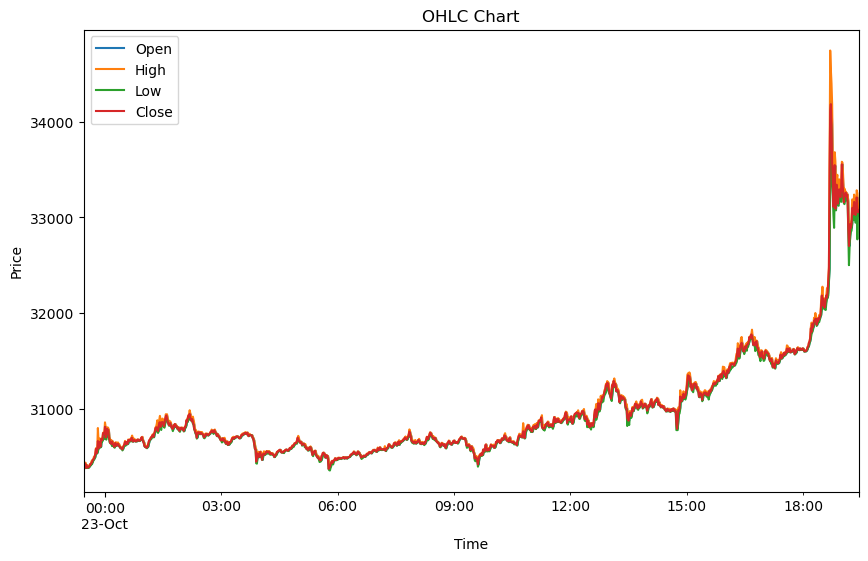

In [5]:
combined_OHLC[['Open', 'High', 'Low', 'Close']].plot(style='-', figsize=(10, 6))

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('OHLC Chart')

plt.show()


OHLC Data Function

In [6]:
def get_OHLC_data(symbol, timeframe, time, limit=1000):
    
    since_time = datetime.utcnow() - timedelta(days=time) # Length of time of data from the duration in days since today historically (could change to hours if wanted)
    
    combined_OHLC = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    
    while since_time < datetime.utcnow(): # Looping in increments of limited 1000 calls until since_time reaches the current time
        current_since_time = int(since_time.timestamp()) * 1000
        
        OHLC_data = pd.DataFrame(exchange.fetch_ohlcv(
            symbol=symbol,
            timeframe=timeframe,
            since=current_since_time,
            limit=limit
        ), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
        
        combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
        
        since_time += timedelta(minutes=(limit * int(timeframe[:-1])))  # Increment by limit minutes
    
    combined_OHLC['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in combined_OHLC['Time']]
    combined_OHLC.set_index('Time', inplace=True)
    
    return combined_OHLC

# Example
symbol = 'BTC/USDT' 
timeframe = '1m'
time = 7 # Number of days since now

OHLC_data = get_OHLC_data(symbol, timeframe, time)
OHLC_data

,Open,High,Low,Close,Volume
Time,,,,,
2023-11-14 06:51:00,36315.39,36322.84,36315.38,36319.96,9.66921
2023-11-14 06:52:00,36319.95,36329.24,36315.51,36319.99,13.81642
2023-11-14 06:53:00,36319.98,36319.99,36305.97,36309.99,5.10105
2023-11-14 06:54:00,36309.99,36329.23,36309.99,36329.23,9.88894
2023-11-14 06:55:00,36329.23,36330.00,36254.88,36256.57,23.76465
...,...,...,...,...,...
2023-11-21 01:46:00,37387.37,37387.38,37381.57,37381.58,4.36200
2023-11-21 01:47:00,37381.57,37383.77,37381.57,37383.53,5.49431
2023-11-21 01:48:00,37383.52,37383.53,37383.52,37383.52,2.88697


Data Quality Checker

In [21]:
def check_data_quality(df):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Check for duplicates
    duplicates = df.duplicated().sum()
    duplicate_rows = None
    if duplicates != 0:
        duplicate_rows = df[df.duplicated()]
        duplicate_rows = duplicate_rows.groupby(list(df)).apply(lambda x: tuple(x.index)).tolist()

    return {
        "Missing Values": missing_values,
        "Duplicates": duplicate_rows,
    }

Data Check for OHLC Data

In [20]:
quality_report = check_data_quality(OHLC_data)

print("Data Quality Report:")
for check, result in quality_report.items():
    print(f"\n{check}:\n{result}")

Data Quality Report:

Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Duplicates:
None


Test if function works for a basic data set with duplicates

In [23]:
data = {
    'A': [1, 4, 1, 7, 10, 4, 1],
    'B': [2, 5, 2, 8, 11, 5, 2],
    'C': [3, 6, 3, 9, 12, 6, 3]
}

df = pd.DataFrame(data)

check_data_quality(df)

{'Missing Values': A    0
 B    0
 C    0
 dtype: int64,
 'Duplicates': [(2, 6), (5,)]}

Data pulling and compression for BTC

In [7]:
def get_all_OHLC_data(symbol, timeframe, limit=1000):
    combined_OHLC = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    
    while True:  # Continue fetching data until there is no more historical data
        if combined_OHLC.empty:
            since_time = datetime.utcnow() - timedelta(days=365 * 10)  # Start fetching data from 10 years ago
        else:
            since_time = datetime.fromtimestamp(combined_OHLC['Time'].iloc[-1] / 1000) + timedelta(minutes=limit * int(timeframe[:-1]))
            
        current_since_time = int(since_time.timestamp()) * 1000
        
        OHLC_data = pd.DataFrame(exchange.fetch_ohlcv(
            symbol=symbol,
            timeframe=timeframe,
            since=current_since_time,
            limit=limit
        ), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
        
        if len(OHLC_data) == 0:
            break  # Break the loop if no more data is available
        
        combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
    
    combined_OHLC['Time'] = [datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC['Time']]
    combined_OHLC.set_index('Time', inplace=True)
    
    return combined_OHLC

symbol = 'BTC/USDT' 
timeframe = '1h'

all_BTC_OHLC_data = get_all_OHLC_data(symbol, timeframe)
all_BTC_OHLC_data

,Open,High,Low,Close,Volume
Time,,,,,
2017-08-17 00:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 01:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 02:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 03:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 04:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2023-11-20 21:00:00,37600.61,37649.44,37419.57,37452.34,1203.934890
2023-11-20 22:00:00,37452.33,37555.99,37399.99,37464.86,827.177770
2023-11-20 23:00:00,37464.86,37480.17,37388.00,37389.98,439.333590


In [9]:
import h5py 

symbol = 'BTC/USDT' 

def HDF5_converter(dataset, symbol):
    with h5py.File('/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5', 'w') as hdf:
        group = hdf.create_group('Token_Warehouse') # Outermost group for all potential tokens
        symbol_group = group.create_group(f'{symbol}_group') # Subgroup for each token due to splitting datetime and OHLC data

        datetime_index_np = dataset.index.values.astype(h5py.opaque_dtype(dataset.index.dtype))

        symbol_group.create_dataset('datetime_index', data=datetime_index_np, compression="gzip", compression_opts=9)

        symbol_group.create_dataset('symbol', data = dataset, compression="gzip", compression_opts=9)


HDF5_converter(all_BTC_OHLC_data, symbol)

with h5py.File('/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5', 'r') as hdf:
    datetime_index = pd.to_datetime(hdf['Token_Warehouse'][f'{symbol}_group']['datetime_index'][:])
    
    data = hdf['Token_Warehouse'][f'{symbol}_group']['symbol'][:]
    
    read_data = pd.DataFrame(data, index=datetime_index, columns=all_BTC_OHLC_data.columns)
    
    print("Read Data:")
    print(read_data)

Read Data:
                         Open      High       Low     Close       Volume
2017-08-17 00:00:00   4261.48   4313.62   4261.32   4308.83    47.181009
2017-08-17 01:00:00   4308.83   4328.69   4291.37   4315.32    23.234916
2017-08-17 02:00:00   4330.29   4345.45   4309.37   4324.35     7.229691
2017-08-17 03:00:00   4316.62   4349.99   4287.41   4349.99     4.443249
2017-08-17 04:00:00   4333.32   4377.85   4333.32   4360.69     0.972807
...                       ...       ...       ...       ...          ...
2023-11-20 21:00:00  37600.61  37649.44  37419.57  37452.34  1203.934890
2023-11-20 22:00:00  37452.33  37555.99  37399.99  37464.86   827.177770
2023-11-20 23:00:00  37464.86  37480.17  37388.00  37389.98   439.333590
2023-11-21 00:00:00  37389.99  37398.81  37316.00  37355.89   676.296470
2023-11-21 01:00:00  37355.90  37411.10  37322.00  37375.09   505.493320

[53914 rows x 5 columns]


Mutiple token data fetcher

In [5]:
def get_all_OHLC_data(symbols, timeframe, limit=1000):
    all_combined_OHLC = {}

    for symbol in symbols:
        combined_OHLC = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

        while True:  # Continue fetching data until there is no more historical data
            if combined_OHLC.empty:
                since_time = datetime.utcnow() - timedelta(days=365 * 10)  # Start fetching data from 10 years ago
            else:
                since_time = datetime.fromtimestamp(combined_OHLC['Time'].iloc[-1] / 1000) + timedelta(minutes=limit * int(timeframe[:-1]))

            current_since_time = int(since_time.timestamp()) * 1000

            OHLC_data = pd.DataFrame(exchange.fetch_ohlcv(
                symbol=symbol,
                timeframe=timeframe,
                since=current_since_time,
                limit=limit
            ), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

            if len(OHLC_data) == 0:
                break  # Break the loop if no more data is available

            combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)

        combined_OHLC['Time'] = [datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC['Time']]
        combined_OHLC.set_index('Time', inplace=True)

        all_combined_OHLC[symbol] = combined_OHLC

    return all_combined_OHLC

# Example usage for fetching data for 10 coins
symbols = ['BTC/USDT', 'ETH/USDT', 'BNB/USDT', 'XRP/USDT', 'SOL/USDT', 'ADA/USDT', 'DOGE/USDT', 'TRX/USDT', 'LINK/USDT', 'AVAX/USDT']
timeframe = '1m'

all_coins_data = get_all_OHLC_data(symbols, timeframe)

In [6]:
btc_data = all_coins_data['BTC/USDT']

btc_data

,Open,High,Low,Close,Volume
Time,,,,,
2017-08-17 00:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 00:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 00:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 00:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 00:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2023-11-23 05:32:00,37509.67,37515.68,37507.91,37507.92,18.370290
2023-11-23 05:33:00,37507.91,37515.68,37501.10,37501.10,11.051480
2023-11-23 05:34:00,37501.11,37501.11,37485.99,37486.00,10.619080


Multiple token converter

In [10]:
def HDF5_converter(all_datasets, output_path='/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5'):
    with h5py.File(output_path, 'w') as hdf:
        group = hdf.create_group('Token_Warehouse')  # Outermost group for all potential tokens

        for symbol, dataset in all_datasets.items():
            symbol_group = group.create_group(f'{symbol}_group')  # Subgroup for each token due to splitting datetime and OHLC data

            # Convert the datetime index to a NumPy array with opaque dtype
            datetime_index_np = dataset.index.values.astype(h5py.opaque_dtype(dataset.index.dtype))

            # Save the datetime index as a separate dataset
            symbol_group.create_dataset('datetime_index', data=datetime_index_np, compression="gzip", compression_opts=9)

            # Save the main dataset
            symbol_group.create_dataset('symbol', data=dataset.values, compression="gzip", compression_opts=9)


HDF5_converter(all_coins_data)

Basic Test

In [11]:
with h5py.File('/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5', 'r') as hdf:
    print("File Structure:")
    print(list(hdf.keys()))
    

File Structure:
['Token_Warehouse']


In [13]:
with h5py.File('/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5', 'r') as hdf:
    if 'Token_Warehouse' in hdf:
        print("'Token_Warehouse' group exists.")
        symbol_group = hdf['Token_Warehouse']['BTC/USDT_group']
        if 'symbol' in symbol_group:
            print("'symbol' dataset exists.")
        else:
            print("'symbol' dataset does not exist.")
    else:
        print("'Token_Warehouse' group does not exist.")

'Token_Warehouse' group exists.
'symbol' dataset exists.
